In [ ]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# !pip install nltk
# !pip install torchtext

In [184]:
import os
path_to_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

Dataset not found locally. Downloading from github.
File ‘data.txt’ already there; not retrieving.



In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab
from nltk.tokenize import wordpunct_tokenize

import numpy as np
import pandas as pd
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

In [186]:
# Step 1: Read the dataset file and parse it
def read_dataset(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    english_sentences = []
    russian_sentences = []
    for line in lines:
        english, russian = line.strip().split('\t')
        english_sentences.append(english)
        russian_sentences.append(russian)
    return english_sentences, russian_sentences

english_sentences, russian_sentences = read_dataset(path_to_data)

# Step 2: Tokenize the sentences
def tokenize_sentences(sentences):
    tokenized_sentences = [wordpunct_tokenize(sentence.lower()) for sentence in sentences]
    return tokenized_sentences

english_tokenized = tokenize_sentences(english_sentences)
russian_tokenized = tokenize_sentences(russian_sentences)

In [187]:
print(len(english_sentences))
print(english_sentences[0])

50000
Cordelia Hotel is situated in Tbilisi, a 3-minute walk away from Saint Trinity Church.


In [188]:
# Step 3: Create vocabulary mappings
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    vocab = torchtext.vocab.vocab(counter, min_freq=3, specials=('<UNK>', '<SOS>', '<EOS>', '<PAD>'))
    vocab.set_default_index(vocab["<UNK>"])
    return vocab

english_vocab = build_vocab(english_tokenized)
russian_vocab = build_vocab(russian_tokenized)

In [189]:
INPUT_DIM = len(russian_vocab)
OUTPUT_DIM = len(english_vocab)
PAD_IDX = english_vocab['<PAD>']
SOS_IDX = english_vocab['<SOS>']
EOS_IDX = english_vocab['<EOS>']
UNK_IDX = english_vocab['<UNK>']

In [190]:
print(len(english_vocab))
print(len(russian_vocab))

7828
10799


In [191]:
# Step 4: Convert tokenized sentences into sequences of integer indices
def sentence_to_indices(tokenized_sentences, vocab):
    indices = [[vocab['<SOS>']] + [vocab[token] for token in sentence] + [vocab['<EOS>']] for sentence in tokenized_sentences]
    return indices

english_indices = sentence_to_indices(english_tokenized, english_vocab)
russian_indices = sentence_to_indices(russian_tokenized, russian_vocab)

In [192]:
MAX_SEQUENCE_LENGTH = 50
BATCH_SIZE = 128

In [193]:
# Step 5: Pad sequences to a fixed length
def pad_sequences(indices, max_length, padding_idx):
    padded_indices = [sentence[:max_length] + [padding_idx] * (max_length - len(sentence)) for sentence in indices]
    return torch.tensor(padded_indices)

english_padding_idx = english_vocab['<PAD>']
russian_padding_idx = russian_vocab['<PAD>']
english_padded = pad_sequences(english_indices, MAX_SEQUENCE_LENGTH, english_padding_idx)
russian_padded = pad_sequences(russian_indices, MAX_SEQUENCE_LENGTH, russian_padding_idx)

In [194]:
# Step 6: Split the dataset into training and validation sets
dataset = list(zip(russian_padded, english_padded))
train_size = int(0.8 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [195]:
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
ENC_HID_DIM = 900
DEC_HID_DIM = 900
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

lr = 0.0005

In [196]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.rnn = nn.GRU(embedding_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        output, hidden = self.rnn(embedded)
        return output, hidden

In [197]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        query = query.unsqueeze(0).permute(1, 0, 2)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)
        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)
        return context

In [198]:
class AttnDecoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(AttnDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.attention = Attention(hidden_size)
        self.rnn = nn.GRU(embedding_size + hidden_size, hidden_size, batch_first=True,
                          num_layers=n_layers, dropout=dropout_p)
        self.dropout = nn.Dropout(dropout_p)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        context = self.attention(hidden[-1], encoder_outputs)
        input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(input, hidden)
        output = self.out(output)
        return output, hidden

In [199]:
class AttnSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(AttnSeq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.device = device

    def forward(self, input, target_tensor=None):
        encoder_outputs, encoder_hidden = self.encoder(input)

        seq_length = MAX_SEQUENCE_LENGTH
        if target_tensor is not None:
            seq_length = target_tensor.shape[1]

        decoder_input = torch.empty(input.shape[0], 1, dtype=torch.long, device=device).fill_(SOS_IDX)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(1, seq_length):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [200]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

encoder = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, N_LAYERS, ENC_DROPOUT)
decoder = AttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, DEC_HID_DIM, OUTPUT_DIM, N_LAYERS, DEC_DROPOUT)

model = AttnSeq2Seq(encoder, decoder, device).to(device)

cuda


In [201]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [202]:
def train(model, iterator, optimizer, criterion, clip, n_show = 50, train_history=None, valid_history=None):
    model.train()

    epoch_loss = 0
    train_loss = 0
    I_val = []
    history = []
    val_history = []
    for i, batch in enumerate(iterator):
        src = batch[0].to(device)
        trg = batch[1].to(device)

        optimizer.zero_grad()

        output = model(src, trg)

        output = output.view(-1, output.shape[-1])
        trg_output = trg[:, 1:].reshape(-1)

        loss = criterion(output, trg_output)

        loss.backward()

        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item()

        history.append(loss.detach().cpu().data.numpy())
        if (i+1) % n_show == 0:
            I_val.append(i)
            val_history.append(evaluate(model, val_loader, criterion))

            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].plot(I_val, val_history, label='validation loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Loss')
            ax[0].legend()
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()


    return epoch_loss / len(iterator)

In [203]:
def evaluate(model, iterator, criterion):

    model.eval()

    epoch_loss = 0

    history = []

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src)

            output = output.view(-1, output.shape[-1])
            trg_output = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg_output)

            epoch_loss += loss.item()
    model.train()
    return epoch_loss / len(iterator)

In [204]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [205]:
n_show = 100
N_EPOCHS = 1
CLIP = 3.0

best_valid_loss = float('inf')

train_history = []
valid_history = []

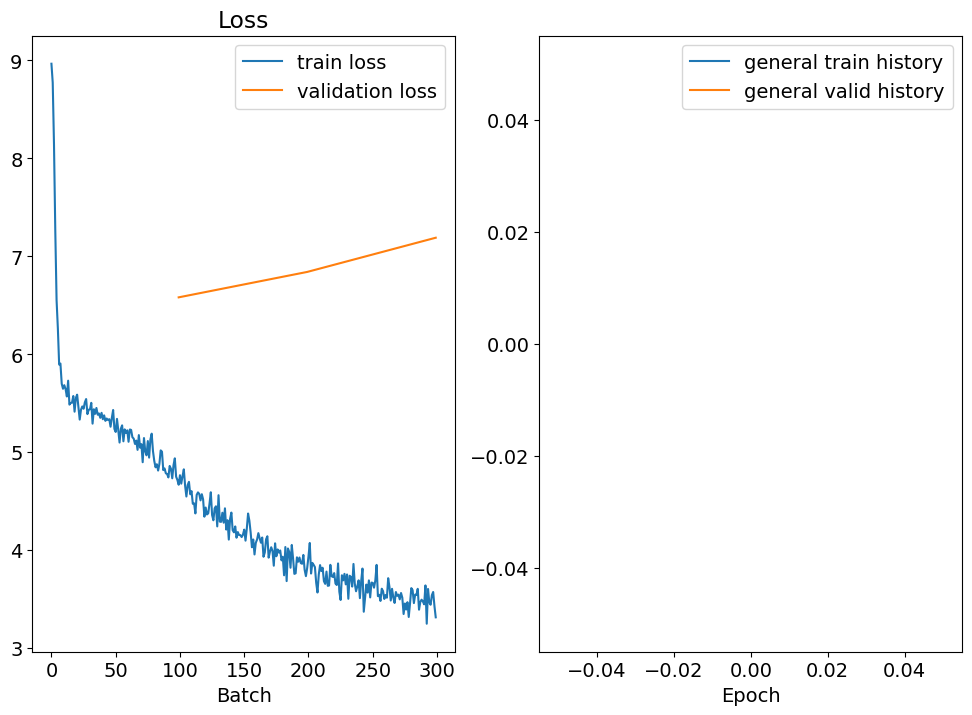

Epoch: 01 | Time: 6m 23s
	Train Loss: 4.358 | Train PPL:  78.115
	 Val. Loss: 7.199 |  Val. PPL: 1337.814


In [206]:
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, CLIP, n_show, train_history, valid_history)
    valid_loss = evaluate(model, val_loader, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

In [207]:
test_loss = evaluate(model, test_loader, criterion)
print('Test loss:', test_loss)

Test loss: 7.196735607950311


In [208]:
batch = next(iter(train_loader))

In [209]:
for idx in [1,2]:
    src = batch[0]
    trg = batch[1][idx:idx+1, :]
    output = model(src.to(device)).argmax(dim=-1).detach().cpu().numpy()[idx:idx+1, :]
    print(output)

[[ 67   0   0   0  40  10 198  32  10 241  20   2  20   2  20   2   5 157
   20   2  20   2  20   2  20   2  20   2  20   2  20   2  20   2  20   2
   20   2  20   2  20   2  20   2  20   2  20   2  20]]
[[ 67 551 233   5  10 183  12  13 159  16  67 160   9 396   0   5  10  85
   12  13 159  16  67 160  20   2 164  16  67 160  20   2  20   2 164  16
   67 160  20   2 233   5   2  20   2 164  15  20   2]]


In [210]:
from nltk.translate.bleu_score import corpus_bleu
import tqdm

In [211]:
# Translate test data and get model translations
translated_sentences = []
target_sentences = []

for batch in tqdm.tqdm(test_loader):
    src = batch[0].to(device)
    trg = batch[1].to(device)
    model.eval()
    with torch.no_grad():
        # Assuming your model returns token indices
        translated_indices = model(src).argmax(dim=-1)
        translated_indices = translated_indices.detach().cpu().tolist()

        for indices in translated_indices:
            tmp = []
            for idx in indices:
                if idx == UNK_IDX or idx > 3:
                    tmp.append(english_vocab.lookup_token(idx))
                elif idx == EOS_IDX:
                    break
            translated_sentences.append(tmp)

        trg_indices = trg.detach().cpu().tolist()
        for indices in trg_indices:
            tmp = []
            for idx in indices:
                if idx == UNK_IDX or idx > 3:
                    tmp.append(english_vocab.lookup_token(idx))
                elif idx == EOS_IDX:
                    break
            target_sentences.append(tmp)


100%|██████████| 19/19 [00:06<00:00,  3.04it/s]


In [212]:
# Calculate BLEU score
bleu_score = corpus_bleu([[text] for text in target_sentences], translated_sentences) * 100
print("BLEU Score:", bleu_score)

BLEU Score: 8.531907886489227


In [63]:
print(translated_sentences[0])
print(translated_sentences[1])
print(translated_sentences[2])

['the', '<UNK>', '<UNK>', 'is', 'located', 'in', 'the', '<UNK>', ',', '<UNK>', '<UNK>', 'offers', 'a', 'private', 'bathroom', 'with', 'a', 'terrace', 'and', 'a', 'terrace', '.']
['the', 'nearest', 'airport', 'is', 'a', '5', '-', 'minute', 'drive', 'from', 'the', 'property', ',', 'while', '<UNK>', 'is', '1', 'km', 'away', '.']
['the', 'property', 'offers', 'a', 'private', 'bathroom', 'with', 'a', 'shower', 'and', 'a', 'hairdryer', '.']


In [64]:
print(target_sentences[0])
print(target_sentences[1])
print(target_sentences[2])

['located', 'in', 'budva', ',', 'about', '1', 'km', 'from', 'the', '<UNK>', 'beach', ',', 'apartment', '<UNK>', 'offers', 'a', 'furnished', 'terrace', 'with', 'barbecue', 'facilities', 'and', 'free', 'wi', '-', 'fi', 'access', '.']
['the', 'paje', 'kite', 'beach', 'is', '3', 'km', 'from', 'the', 'hotel', 'and', 'zanzibar', 'international', 'airport', 'is', '45', 'minutes', '’', 'drive', 'away', '.']
['towels', 'and', 'bed', 'linen', 'are', 'offered', 'at', '<UNK>', '.']


In [169]:
for i in range(20):
    print(translated_sentences[i])

['located', 'in', 'the', 'heart', 'of', '<UNK>', ',', '<UNK>', '<UNK>', 'offers', 'self', '-', 'catering', 'accommodation', 'with', 'free', 'wifi', '.']
['the', 'nearest', 'airport', 'is', 'located', 'in', 'the', 'heart', 'of', '<UNK>', ',', 'while', 'the', 'property', 'is', '1', '.', '5', 'km', 'from', 'the', 'property', '.']
['guests', 'can', 'enjoy', 'a', 'terrace', 'and', 'a', 'terrace', '.']
['the', 'property', 'is', 'a', '10', '-', 'minute', 'walk', 'from', 'the', 'property', '.']
['guests', 'can', 'enjoy', 'a', 'terrace', ',', 'a', 'fitness', 'centre', ',', 'the', '<UNK>', '<UNK>', '<UNK>', 'also', 'offers', 'a', 'terrace', '.']
['each', 'room', 'at', 'the', 'hotel', 'has', 'a', 'flat', '-', 'screen', 'tv', '.']
['the', 'property', 'offers', 'free', 'parking', 'and', 'a', 'terrace', '.']
['each', 'room', 'at', 'the', 'hotel', 'has', 'a', 'flat', '-', 'screen', 'tv', '.']
['the', 'kitchen', 'comes', 'with', 'a', 'dishwasher', 'and', 'a', 'hairdryer', '.']
['each', 'room', 'at', '

In [149]:
for i in range(20):
    print(target_sentences[i])

['located', 'in', 'budva', ',', 'about', '1', 'km', 'from', 'the', '<UNK>', 'beach', ',', 'apartment', '<UNK>', 'offers', 'a', 'furnished', 'terrace', 'with', 'barbecue', 'facilities', 'and', 'free', 'wi', '-', 'fi', 'access', '.']
['the', 'paje', 'kite', 'beach', 'is', '3', 'km', 'from', 'the', 'hotel', 'and', 'zanzibar', 'international', 'airport', 'is', '45', 'minutes', '’', 'drive', 'away', '.']
['towels', 'and', 'bed', 'linen', 'are', 'offered', 'at', '<UNK>', '.']
['the', 'property', 'boasts', 'views', 'of', 'the', 'city', 'and', 'is', '1', 'km', 'from', 'pompidou', 'centre', '.']
['each', 'morning', ',', 'guests', 'can', 'enjoy', 'a', 'traditional', 'turkish', 'breakfast', 'under', 'the', '<UNK>', 'on', 'the', '<UNK>', 'terrace', '.']
['all', 'rooms', 'offer', 'a', 'tv', 'with', 'satellite', 'channels', '.']
['guests', 'have', 'access', 'to', 'a', 'shared', 'swimming', 'pool', 'and', 'a', 'car', 'park', '.']
['rooms', 'here', 'feature', 'a', 'tv', 'with', 'cable', 'channels', '.

In [224]:
def sentence2tokens(sentence, lang='en'):
    return wordpunct_tokenize(sentence.lower())

def tokens2indices(tokens, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    return [vocab['<SOS>']] + [vocab.lookup_indices(tokens)] + [vocab['<EOS>']]

def indices2tensor(indices, lang='en'):
    return torch.tensor(indices, dtype=torch.long).view(1, -1)

def indices2tokens(indices, lang='en', remove_specials=True):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    tokens = []
    if remove_specials:
        for idx in indices:
            if idx == UNK_IDX or idx > 3:
                tokens.append(english_vocab.lookup_token(idx))
            elif idx == EOS_IDX:
                break
        return tokens
    else:
        return vocab.lookup_tokens(indices)

def tokens2sentence(tokens, lang='en'):
    return "".join(tokens)

def translate_tensor_to_tensor(model, input):
    input = input.unsqueeze(1)
    model.eval()
    with torch.no_grad():
        input = input.to(device)
        return model(input).argmax(dim=-1)

def translate_indices_to_indices(model, indices):
    input = indices2tensor(indices)
    return translate_tensor_to_tensor(model, input).detach().cpu().tolist()

def translate_tokens_to_tokens(tokens):
    indices = tokens2indices(tokens, lang='ru')
    translated_indices = translate_indices_to_indices(indices)
    return indices2tokens(translated_indices, lang='en')

def translate_tensor_to_tokens(model, input):
    indices = translate_tensor_to_tensor(model, input).detach().cpu().tolist()[0]
    return indices2tokens(indices)


def translate_batch(model, input):
    pass

In [225]:
tnp = translate_tensor_to_tokens(model, batch[0][:, 0])

In [226]:
for i in range(20):
    print(tnp[i])

die
die
die
die
die
die
die
die
die
die
die
die
die
die
die
die
die
die
die
die


In [180]:
src = indices2tokens(batch[0].tolist(), lang='ru')
tgt = indices2tokens(batch[1].tolist())

In [181]:
for i in range(10):
    print(src[i])
    print(tgt[i])
    print('\n----------------\n')

['<SOS>', 'кроме', 'того', ',', 'гости', 'могут', 'пользоваться', 'помещениями', 'для', 'проведения', 'конференций', ',', 'факсом', 'и', 'услугами', 'ксерокопирования', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', 'in', 'addition', ',', 'guests', 'can', 'also', 'make', 'use', 'of', 'the', 'meeting', 'facilities', 'and', 'fax', '/', 'photocopying', '.', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

----------------

['<SOS>', 'международный', 'аэропорт', 'тбилиси', 'находится', 'в', '14

In [81]:
crit_tmp = nn.CrossEntropyLoss()

In [85]:
src = batch[0].to(device)
trg = batch[1].to(device)

output = model(src)

output = output.view(-1, output.shape[-1])
trg_output = trg[:, 1:].reshape(-1)

loss = criterion(output, trg_output)

In [86]:
print(loss)

tensor(2.9075, device='cuda:0', grad_fn=<NllLossBackward0>)


# Arcive

In [ ]:
def indeces_from_sentence(sentence, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    return vocab.lookup_indeces(tokens)

def tensor_from_sentence(sentence, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    indeces = [vocab['<SOS>']] + indeces_from_sentence(sentence, lang) + [vocab['<EOS>']]
    return torch.tensor(indeces, dtype=torch.long).view(1, -1)


def tensor_from_tokens(tokens, lang='en'):
    if lang == 'en':
        vocab = english_vocab
    elif lang == 'ru':
        vocab = russian_vocab

    indeces = [vocab['<SOS>']] + vocab.lookup_indeces(tokens) + [vocab['<EOS>']]
    return torch.tensor(indeces, dtype=torch.long).view(1, -1)

def tensor_from_indeces(indeces):
    torch.tensor(indeces, dtype=torch.long).view(1, -1)


def translate_sentence_to_indeces(model, input):
    input = tensorFromSentence(input, lang='ru')

    model.eval()
    with torch.no_grad():
        input = input.to(device)

        # Assuming your model returns token indices
        raw_indices = model(input).argmax(dim=-1)
        raw_indices = raw_indices.detach().cpu().tolist()
        translated_indices = []
        for idx in raw_indices:
            or idx in indices:
                if idx == UNK_IDX or idx > 3:
                    translated_indices.append(english_vocab.lookup_token(idx))
                elif idx == EOS_IDX:
                    break
    return translated_indices


def translate_tokens_to_tokens(model, tokens):


def translate_sentence_to_tokens(model, sentence):
    indeces = translate_sentence_to_indeces(model, sentence)
    return indices2tokens(indeces)

def translate_sentence_to_sentence(model, sentence):
    indeces = translate_sentence_to_indeces(model, sentence)
    tokens = indices2tokens(indeces)
    return tokens2sentence(tokens)